In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import tifffile as tfl
import h5py
import tensorflow as tf
import richdem as rd
from tensorflow import keras
from tqdm.notebook import tqdm_notebook
%matplotlib inline

In [19]:
os.chdir('D:/Landslide')

In [20]:
%ls

 Volume in drive D is Remote Sensing and GIS data
 Volume Serial Number is 78A5-4D3B

 Directory of D:\Landslide

04/18/2022  05:55 PM    <DIR>          .
04/18/2022  05:55 PM    <DIR>          ..
04/18/2022  10:37 AM                38 .gitignore
04/18/2022  10:27 AM    <DIR>          .ipynb_checkpoints
04/18/2022  09:09 AM         1,324,307 0.EDA for Landslide4Sense.ipynb
04/18/2022  05:55 PM           927,338 1. Data Loader.ipynb
04/18/2022  10:27 AM         1,606,568 2.Slope_and_Aspect_Map_reading.ipynb
04/18/2022  10:25 AM           711,093 3.U_net & Deep U_net Model.ipynb
04/18/2022  11:13 AM           297,816 Mapping landslides from EO data using deep-learning methods.pdf
04/18/2022  05:53 PM    <DIR>          npy_data
04/17/2022  09:22 PM    <DIR>          Sample
04/17/2022  05:36 PM    <DIR>          TrainData
04/14/2022  08:06 PM     2,442,381,619 TrainData.zip
04/18/2022  11:15 AM         4,858,605 U-Net and ResU-Net.pdf
               8 File(s)  2,452,107,384 bytes
         

In [21]:
folder_list = sorted(os.listdir('D:/Landslide/TrainData/img'))
mask_folder_list =sorted(os.listdir(r'D:/Landslide/TrainData/mask'))
#mask_folder_list.remove('collection.json')

# train_dir = '../input/severstal-steel-defect-detection/' # directory of training images


In [22]:
print(f'Image name is {folder_list[110]}')
print(f'Mask name is {mask_folder_list[110]}')
print(f'Number of items in Folder List {len(folder_list)}')
print(f'Number of items in mask list {len(mask_folder_list)}')

Image name is image_1099.h5
Mask name is mask_1099.h5
Number of items in Folder List 3798
Number of items in mask list 3798


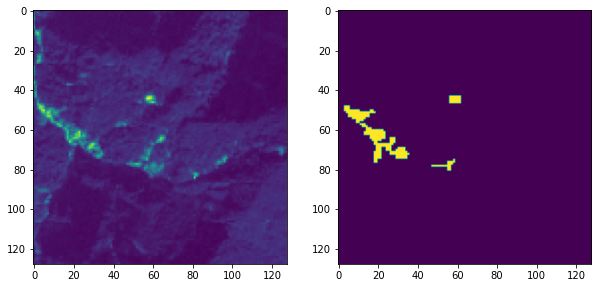

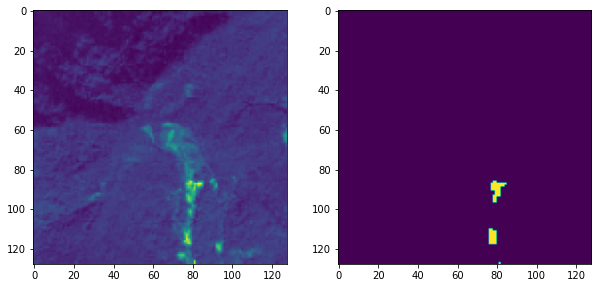

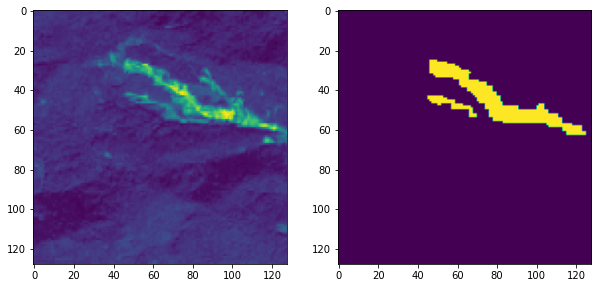

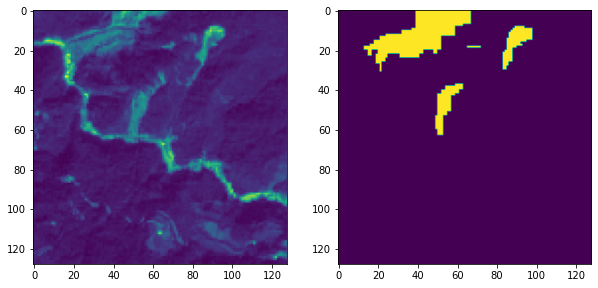

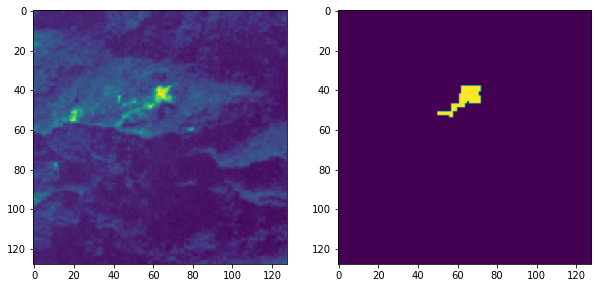

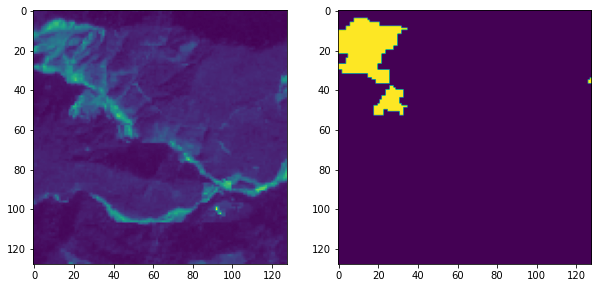

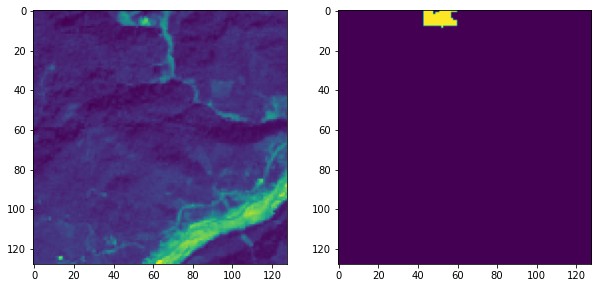

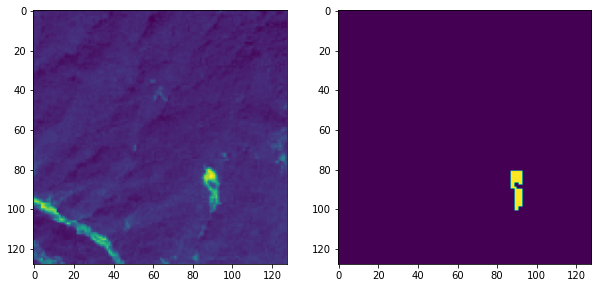

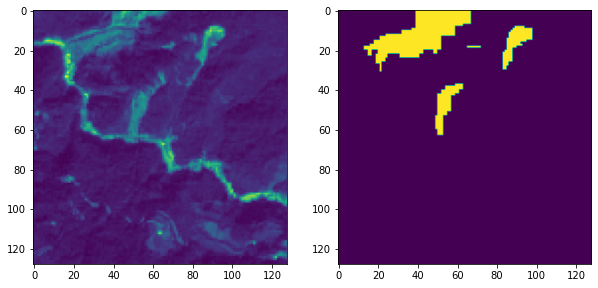

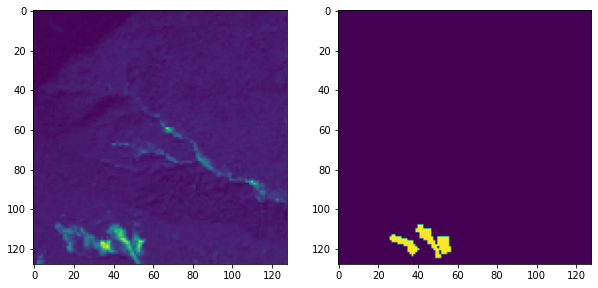

In [23]:
# # Dataloader for Pytorch
dataset_dir='D:/Landslide/TrainData/img/'
mask_dir='D:/Landslide/TrainData/mask/'

class data_loader():
    def __init__(self,dataset_dir,mask_dir):
        self.dataset_dir = dataset_dir
        self.mask_dir = mask_dir
        
        folder_list = os.listdir(self.dataset_dir)
        mask_folder_list = os.listdir(self.mask_dir)

    def __getitem__(self,idx):
        image = self.get_image(folder_list[idx])
        mask = self.get_mask_image(mask_folder_list[idx])
    
        return image,mask
    
    def get_image(self,folder_dir):
        image = h5py.File(dataset_dir+folder_dir,'r')
        image = np.array(image.get('img'))
        
#         image = tfl.imread(dataset_dir+folder_dir)
    
        return image
    
    def get_mask_image(self,folder_dir):
        image = h5py.File(mask_dir+folder_dir,'r')
        image = np.array(image.get('mask'))
#         label = np.array(Image.open(mask_dir+folder_dir+'/labels.tif'))
        
        return image
    
training_data = data_loader(dataset_dir,mask_dir)

for i in range(10):
    n = np.random.randint(1,100)
    fig,(ax1,ax2)= plt.subplots(1,2,figsize=(10,10))
    ax1.imshow(training_data[n][0][:,:,1])
    ax2.imshow(training_data[n][1])

In [39]:
len(training_data[0][0]),len(sat_data1[0][0])

(128, 100)

# Tensorflow DataLoader

In [34]:

dataset_dir='D:/Landslide/TrainData/img/'
mask_dir='D:/Landslide/TrainData/mask/'

class data_loader(keras.utils.Sequence):
    def __init__(self, batch_size, img_size,num_classes,dataset_dir,mask_dir):
        self.batch_size = batch_size
        self.img_size = img_size
        self.dataset_dir = dataset_dir
        self.mask_dir = mask_dir
        self.num_classes= num_classes
        self.folder_list = sorted(os.listdir(self.dataset_dir))
        self.mask_folder_list = sorted(os.listdir(self.mask_dir))


    def __len__(self):
        return len(self.folder_list)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.folder_list[i : i + self.batch_size]
        batch_target_img_paths = self.mask_folder_list[i : i + self.batch_size]

        # load images
        x = np.zeros((self.batch_size,) + self.img_size + (14,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = self.get_image(self.dataset_dir+path)
            x[j] = img

        # load masks
        y = np.zeros((self.batch_size,) + self.img_size, dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = self.get_mask_image(self.mask_dir+path)
            y[j] = img  

        return x,y



    def get_image(self,folder_dir):
        image = h5py.File(folder_dir,'r')
        image = np.array(image.get('img'))
        data1 = image[:,:,1] #Band 2
        data2 = image[:,:,2] #Band 3
        data3 = image[:,:,3] #Band 4
        data4 = image[:,:,7] #Band 8
        data5 = image[:,:,13] # DEM data
        data5 = rd.rdarray(data5,no_data= -99999) #Reading DEM data with rdarray
        aspect = rd.TerrainAttribute(data5,attrib='aspect') # Calculating Aspect
        
        image = np.moveaxis(np.stack((data1,data2,data3,data4,aspect)),0,2)
        
        return image
    
    def get_mask_image(self,folder_dir):
        image = h5py.File(folder_dir,'r')
        image = np.array(image.get('mask'))

        
        return image

In [35]:
sat_data1 = data_loader(100,(128,128),14,dataset_dir,mask_dir)
val_gen = data_loader(10,(128,128),14,dataset_dir,mask_dir)

In [ ]:
len(sat_data1),len(val_gen)

In [ ]:
x,y = val_gen[0]
print(x.shape)
print(y.shape)
for i in range(10):
    n = np.random.randint(1,2)
    fig,(ax1,ax2)= plt.subplots(1,2,figsize=(10,10))
    # ax1.imshow(x[n][0][:,:,1])
    ax1.imshow(x[n][:,:,1])
    ax2.imshow(y[n])

In [ ]:
x,y = sat_data1[3]
print(x.shape)
print(y.shape)
for i in range(10):
    n = np.random.randint(1,10)
    fig,(ax1,ax2)= plt.subplots(1,2,figsize=(10,10))
    # ax1.imshow(x[n][0][:,:,1])
    ax1.imshow(x[n][:,:,1])
    ax2.imshow(y[n])

In [4]:
# path ='D:/Landslide/TrainData/'

# train_path = 'D:/Landslide/TrainData/img/'
# label_path = 'D:/Landslide/TrainData/mask/'

# img_height =128 
# img_width = 128
# img_channels = 14

# train_ids = sorted(next(os.walk(train_path)) [2])
# print(train_ids[100])
# label_ids = sorted(next(os.walk(label_path)) [2])
# print(label_ids[100])



image_109.h5
mask_109.h5


In [5]:
# print(len(train_ids))
# print(len(label_ids))

3798
3798


In [6]:
# X_train = np.zeros((len(train_ids),img_height, img_width, img_channels ), dtype=np.float)
# Y_train = np.zeros((len(label_ids),img_height,img_width),dtype=np.bool)

In [7]:
# for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
#     path = train_path + id_
#     print(path)
#     img = h5py.File(path,'r')
#     img = np.array(img.get('img'))
#     X_train[n]=img

  0%|          | 0/3798 [00:00<?, ?it/s]

D:/Landslide/TrainData/img/image_10.h5
D:/Landslide/TrainData/img/image_100.h5
D:/Landslide/TrainData/img/image_1000.h5
D:/Landslide/TrainData/img/image_1001.h5
D:/Landslide/TrainData/img/image_1002.h5
D:/Landslide/TrainData/img/image_1003.h5
D:/Landslide/TrainData/img/image_1004.h5
D:/Landslide/TrainData/img/image_1005.h5
D:/Landslide/TrainData/img/image_1006.h5
D:/Landslide/TrainData/img/image_1007.h5
D:/Landslide/TrainData/img/image_1008.h5
D:/Landslide/TrainData/img/image_1009.h5
D:/Landslide/TrainData/img/image_101.h5
D:/Landslide/TrainData/img/image_1010.h5
D:/Landslide/TrainData/img/image_1011.h5
D:/Landslide/TrainData/img/image_1012.h5
D:/Landslide/TrainData/img/image_1013.h5
D:/Landslide/TrainData/img/image_1014.h5
D:/Landslide/TrainData/img/image_1015.h5
D:/Landslide/TrainData/img/image_1016.h5
D:/Landslide/TrainData/img/image_1017.h5
D:/Landslide/TrainData/img/image_1018.h5
D:/Landslide/TrainData/img/image_1019.h5
D:/Landslide/TrainData/img/image_102.h5
D:/Landslide/TrainDat

D:/Landslide/TrainData/img/image_1185.h5
D:/Landslide/TrainData/img/image_1186.h5
D:/Landslide/TrainData/img/image_1187.h5
D:/Landslide/TrainData/img/image_1188.h5
D:/Landslide/TrainData/img/image_1189.h5
D:/Landslide/TrainData/img/image_119.h5
D:/Landslide/TrainData/img/image_1190.h5
D:/Landslide/TrainData/img/image_1191.h5
D:/Landslide/TrainData/img/image_1192.h5
D:/Landslide/TrainData/img/image_1193.h5
D:/Landslide/TrainData/img/image_1194.h5
D:/Landslide/TrainData/img/image_1195.h5
D:/Landslide/TrainData/img/image_1196.h5
D:/Landslide/TrainData/img/image_1197.h5
D:/Landslide/TrainData/img/image_1198.h5
D:/Landslide/TrainData/img/image_1199.h5
D:/Landslide/TrainData/img/image_12.h5
D:/Landslide/TrainData/img/image_120.h5
D:/Landslide/TrainData/img/image_1200.h5
D:/Landslide/TrainData/img/image_1201.h5
D:/Landslide/TrainData/img/image_1202.h5
D:/Landslide/TrainData/img/image_1203.h5
D:/Landslide/TrainData/img/image_1204.h5
D:/Landslide/TrainData/img/image_1205.h5
D:/Landslide/TrainDa

D:/Landslide/TrainData/img/image_137.h5
D:/Landslide/TrainData/img/image_1370.h5
D:/Landslide/TrainData/img/image_1371.h5
D:/Landslide/TrainData/img/image_1372.h5
D:/Landslide/TrainData/img/image_1373.h5
D:/Landslide/TrainData/img/image_1374.h5
D:/Landslide/TrainData/img/image_1375.h5
D:/Landslide/TrainData/img/image_1376.h5
D:/Landslide/TrainData/img/image_1377.h5
D:/Landslide/TrainData/img/image_1378.h5
D:/Landslide/TrainData/img/image_1379.h5
D:/Landslide/TrainData/img/image_138.h5
D:/Landslide/TrainData/img/image_1380.h5
D:/Landslide/TrainData/img/image_1381.h5
D:/Landslide/TrainData/img/image_1382.h5
D:/Landslide/TrainData/img/image_1383.h5
D:/Landslide/TrainData/img/image_1384.h5
D:/Landslide/TrainData/img/image_1385.h5
D:/Landslide/TrainData/img/image_1386.h5
D:/Landslide/TrainData/img/image_1387.h5
D:/Landslide/TrainData/img/image_1388.h5
D:/Landslide/TrainData/img/image_1389.h5
D:/Landslide/TrainData/img/image_139.h5
D:/Landslide/TrainData/img/image_1390.h5
D:/Landslide/TrainD

D:/Landslide/TrainData/img/image_1579.h5
D:/Landslide/TrainData/img/image_158.h5
D:/Landslide/TrainData/img/image_1580.h5
D:/Landslide/TrainData/img/image_1581.h5
D:/Landslide/TrainData/img/image_1582.h5
D:/Landslide/TrainData/img/image_1583.h5
D:/Landslide/TrainData/img/image_1584.h5
D:/Landslide/TrainData/img/image_1585.h5
D:/Landslide/TrainData/img/image_1586.h5
D:/Landslide/TrainData/img/image_1587.h5
D:/Landslide/TrainData/img/image_1588.h5
D:/Landslide/TrainData/img/image_1589.h5
D:/Landslide/TrainData/img/image_159.h5
D:/Landslide/TrainData/img/image_1590.h5
D:/Landslide/TrainData/img/image_1591.h5
D:/Landslide/TrainData/img/image_1592.h5
D:/Landslide/TrainData/img/image_1593.h5
D:/Landslide/TrainData/img/image_1594.h5
D:/Landslide/TrainData/img/image_1595.h5
D:/Landslide/TrainData/img/image_1596.h5
D:/Landslide/TrainData/img/image_1597.h5
D:/Landslide/TrainData/img/image_1598.h5
D:/Landslide/TrainData/img/image_1599.h5
D:/Landslide/TrainData/img/image_16.h5
D:/Landslide/TrainDa

D:/Landslide/TrainData/img/image_1787.h5
D:/Landslide/TrainData/img/image_1788.h5
D:/Landslide/TrainData/img/image_1789.h5
D:/Landslide/TrainData/img/image_179.h5
D:/Landslide/TrainData/img/image_1790.h5
D:/Landslide/TrainData/img/image_1791.h5
D:/Landslide/TrainData/img/image_1792.h5
D:/Landslide/TrainData/img/image_1793.h5
D:/Landslide/TrainData/img/image_1794.h5
D:/Landslide/TrainData/img/image_1795.h5
D:/Landslide/TrainData/img/image_1796.h5
D:/Landslide/TrainData/img/image_1797.h5
D:/Landslide/TrainData/img/image_1798.h5
D:/Landslide/TrainData/img/image_1799.h5
D:/Landslide/TrainData/img/image_18.h5
D:/Landslide/TrainData/img/image_180.h5
D:/Landslide/TrainData/img/image_1800.h5
D:/Landslide/TrainData/img/image_1801.h5
D:/Landslide/TrainData/img/image_1802.h5
D:/Landslide/TrainData/img/image_1803.h5
D:/Landslide/TrainData/img/image_1804.h5
D:/Landslide/TrainData/img/image_1805.h5
D:/Landslide/TrainData/img/image_1806.h5
D:/Landslide/TrainData/img/image_1807.h5
D:/Landslide/TrainDa

D:/Landslide/TrainData/img/image_1978.h5
D:/Landslide/TrainData/img/image_1979.h5
D:/Landslide/TrainData/img/image_198.h5
D:/Landslide/TrainData/img/image_1980.h5
D:/Landslide/TrainData/img/image_1981.h5
D:/Landslide/TrainData/img/image_1982.h5
D:/Landslide/TrainData/img/image_1983.h5
D:/Landslide/TrainData/img/image_1984.h5
D:/Landslide/TrainData/img/image_1985.h5
D:/Landslide/TrainData/img/image_1986.h5
D:/Landslide/TrainData/img/image_1987.h5
D:/Landslide/TrainData/img/image_1988.h5
D:/Landslide/TrainData/img/image_1989.h5
D:/Landslide/TrainData/img/image_199.h5
D:/Landslide/TrainData/img/image_1990.h5
D:/Landslide/TrainData/img/image_1991.h5
D:/Landslide/TrainData/img/image_1992.h5
D:/Landslide/TrainData/img/image_1993.h5
D:/Landslide/TrainData/img/image_1994.h5
D:/Landslide/TrainData/img/image_1995.h5
D:/Landslide/TrainData/img/image_1996.h5
D:/Landslide/TrainData/img/image_1997.h5
D:/Landslide/TrainData/img/image_1998.h5
D:/Landslide/TrainData/img/image_1999.h5
D:/Landslide/Train

D:/Landslide/TrainData/img/image_2168.h5
D:/Landslide/TrainData/img/image_2169.h5
D:/Landslide/TrainData/img/image_217.h5
D:/Landslide/TrainData/img/image_2170.h5
D:/Landslide/TrainData/img/image_2171.h5
D:/Landslide/TrainData/img/image_2172.h5
D:/Landslide/TrainData/img/image_2173.h5
D:/Landslide/TrainData/img/image_2174.h5
D:/Landslide/TrainData/img/image_2175.h5
D:/Landslide/TrainData/img/image_2176.h5
D:/Landslide/TrainData/img/image_2177.h5
D:/Landslide/TrainData/img/image_2178.h5
D:/Landslide/TrainData/img/image_2179.h5
D:/Landslide/TrainData/img/image_218.h5
D:/Landslide/TrainData/img/image_2180.h5
D:/Landslide/TrainData/img/image_2181.h5
D:/Landslide/TrainData/img/image_2182.h5
D:/Landslide/TrainData/img/image_2183.h5
D:/Landslide/TrainData/img/image_2184.h5
D:/Landslide/TrainData/img/image_2185.h5
D:/Landslide/TrainData/img/image_2186.h5
D:/Landslide/TrainData/img/image_2187.h5
D:/Landslide/TrainData/img/image_2188.h5
D:/Landslide/TrainData/img/image_2189.h5
D:/Landslide/Train

D:/Landslide/TrainData/img/image_2355.h5
D:/Landslide/TrainData/img/image_2356.h5
D:/Landslide/TrainData/img/image_2357.h5
D:/Landslide/TrainData/img/image_2358.h5
D:/Landslide/TrainData/img/image_2359.h5
D:/Landslide/TrainData/img/image_236.h5
D:/Landslide/TrainData/img/image_2360.h5
D:/Landslide/TrainData/img/image_2361.h5
D:/Landslide/TrainData/img/image_2362.h5
D:/Landslide/TrainData/img/image_2363.h5
D:/Landslide/TrainData/img/image_2364.h5
D:/Landslide/TrainData/img/image_2365.h5
D:/Landslide/TrainData/img/image_2366.h5
D:/Landslide/TrainData/img/image_2367.h5
D:/Landslide/TrainData/img/image_2368.h5
D:/Landslide/TrainData/img/image_2369.h5
D:/Landslide/TrainData/img/image_237.h5
D:/Landslide/TrainData/img/image_2370.h5
D:/Landslide/TrainData/img/image_2371.h5
D:/Landslide/TrainData/img/image_2372.h5
D:/Landslide/TrainData/img/image_2373.h5
D:/Landslide/TrainData/img/image_2374.h5
D:/Landslide/TrainData/img/image_2375.h5
D:/Landslide/TrainData/img/image_2376.h5
D:/Landslide/Train

D:/Landslide/TrainData/img/image_2542.h5
D:/Landslide/TrainData/img/image_2543.h5
D:/Landslide/TrainData/img/image_2544.h5
D:/Landslide/TrainData/img/image_2545.h5
D:/Landslide/TrainData/img/image_2546.h5
D:/Landslide/TrainData/img/image_2547.h5
D:/Landslide/TrainData/img/image_2548.h5
D:/Landslide/TrainData/img/image_2549.h5
D:/Landslide/TrainData/img/image_255.h5
D:/Landslide/TrainData/img/image_2550.h5
D:/Landslide/TrainData/img/image_2551.h5
D:/Landslide/TrainData/img/image_2552.h5
D:/Landslide/TrainData/img/image_2553.h5
D:/Landslide/TrainData/img/image_2554.h5
D:/Landslide/TrainData/img/image_2555.h5
D:/Landslide/TrainData/img/image_2556.h5
D:/Landslide/TrainData/img/image_2557.h5
D:/Landslide/TrainData/img/image_2558.h5
D:/Landslide/TrainData/img/image_2559.h5
D:/Landslide/TrainData/img/image_256.h5
D:/Landslide/TrainData/img/image_2560.h5
D:/Landslide/TrainData/img/image_2561.h5
D:/Landslide/TrainData/img/image_2562.h5
D:/Landslide/TrainData/img/image_2563.h5
D:/Landslide/Train

D:/Landslide/TrainData/img/image_2723.h5
D:/Landslide/TrainData/img/image_2724.h5
D:/Landslide/TrainData/img/image_2725.h5
D:/Landslide/TrainData/img/image_2726.h5
D:/Landslide/TrainData/img/image_2727.h5
D:/Landslide/TrainData/img/image_2728.h5
D:/Landslide/TrainData/img/image_2729.h5
D:/Landslide/TrainData/img/image_273.h5
D:/Landslide/TrainData/img/image_2730.h5
D:/Landslide/TrainData/img/image_2731.h5
D:/Landslide/TrainData/img/image_2732.h5
D:/Landslide/TrainData/img/image_2733.h5
D:/Landslide/TrainData/img/image_2734.h5
D:/Landslide/TrainData/img/image_2735.h5
D:/Landslide/TrainData/img/image_2736.h5
D:/Landslide/TrainData/img/image_2737.h5
D:/Landslide/TrainData/img/image_2738.h5
D:/Landslide/TrainData/img/image_2739.h5
D:/Landslide/TrainData/img/image_274.h5
D:/Landslide/TrainData/img/image_2740.h5
D:/Landslide/TrainData/img/image_2741.h5
D:/Landslide/TrainData/img/image_2742.h5
D:/Landslide/TrainData/img/image_2743.h5
D:/Landslide/TrainData/img/image_2744.h5
D:/Landslide/Train

D:/Landslide/TrainData/img/image_2905.h5
D:/Landslide/TrainData/img/image_2906.h5
D:/Landslide/TrainData/img/image_2907.h5
D:/Landslide/TrainData/img/image_2908.h5
D:/Landslide/TrainData/img/image_2909.h5
D:/Landslide/TrainData/img/image_291.h5
D:/Landslide/TrainData/img/image_2910.h5
D:/Landslide/TrainData/img/image_2911.h5
D:/Landslide/TrainData/img/image_2912.h5
D:/Landslide/TrainData/img/image_2913.h5
D:/Landslide/TrainData/img/image_2914.h5
D:/Landslide/TrainData/img/image_2915.h5
D:/Landslide/TrainData/img/image_2916.h5
D:/Landslide/TrainData/img/image_2917.h5
D:/Landslide/TrainData/img/image_2918.h5
D:/Landslide/TrainData/img/image_2919.h5
D:/Landslide/TrainData/img/image_292.h5
D:/Landslide/TrainData/img/image_2920.h5
D:/Landslide/TrainData/img/image_2921.h5
D:/Landslide/TrainData/img/image_2922.h5
D:/Landslide/TrainData/img/image_2923.h5
D:/Landslide/TrainData/img/image_2924.h5
D:/Landslide/TrainData/img/image_2925.h5
D:/Landslide/TrainData/img/image_2926.h5
D:/Landslide/Train

D:/Landslide/TrainData/img/image_3090.h5
D:/Landslide/TrainData/img/image_3091.h5
D:/Landslide/TrainData/img/image_3092.h5
D:/Landslide/TrainData/img/image_3093.h5
D:/Landslide/TrainData/img/image_3094.h5
D:/Landslide/TrainData/img/image_3095.h5
D:/Landslide/TrainData/img/image_3096.h5
D:/Landslide/TrainData/img/image_3097.h5
D:/Landslide/TrainData/img/image_3098.h5
D:/Landslide/TrainData/img/image_3099.h5
D:/Landslide/TrainData/img/image_31.h5
D:/Landslide/TrainData/img/image_310.h5
D:/Landslide/TrainData/img/image_3100.h5
D:/Landslide/TrainData/img/image_3101.h5
D:/Landslide/TrainData/img/image_3102.h5
D:/Landslide/TrainData/img/image_3103.h5
D:/Landslide/TrainData/img/image_3104.h5
D:/Landslide/TrainData/img/image_3105.h5
D:/Landslide/TrainData/img/image_3106.h5
D:/Landslide/TrainData/img/image_3107.h5
D:/Landslide/TrainData/img/image_3108.h5
D:/Landslide/TrainData/img/image_3109.h5
D:/Landslide/TrainData/img/image_311.h5
D:/Landslide/TrainData/img/image_3110.h5
D:/Landslide/TrainDa

D:/Landslide/TrainData/img/image_3278.h5
D:/Landslide/TrainData/img/image_3279.h5
D:/Landslide/TrainData/img/image_328.h5
D:/Landslide/TrainData/img/image_3280.h5
D:/Landslide/TrainData/img/image_3281.h5
D:/Landslide/TrainData/img/image_3282.h5
D:/Landslide/TrainData/img/image_3283.h5
D:/Landslide/TrainData/img/image_3284.h5
D:/Landslide/TrainData/img/image_3285.h5
D:/Landslide/TrainData/img/image_3286.h5
D:/Landslide/TrainData/img/image_3287.h5
D:/Landslide/TrainData/img/image_3288.h5
D:/Landslide/TrainData/img/image_3289.h5
D:/Landslide/TrainData/img/image_329.h5
D:/Landslide/TrainData/img/image_3290.h5
D:/Landslide/TrainData/img/image_3291.h5
D:/Landslide/TrainData/img/image_3292.h5
D:/Landslide/TrainData/img/image_3293.h5
D:/Landslide/TrainData/img/image_3294.h5
D:/Landslide/TrainData/img/image_3295.h5
D:/Landslide/TrainData/img/image_3296.h5
D:/Landslide/TrainData/img/image_3297.h5
D:/Landslide/TrainData/img/image_3298.h5
D:/Landslide/TrainData/img/image_3299.h5
D:/Landslide/Train

D:/Landslide/TrainData/img/image_3491.h5
D:/Landslide/TrainData/img/image_3492.h5
D:/Landslide/TrainData/img/image_3493.h5
D:/Landslide/TrainData/img/image_3494.h5
D:/Landslide/TrainData/img/image_3495.h5
D:/Landslide/TrainData/img/image_3496.h5
D:/Landslide/TrainData/img/image_3497.h5
D:/Landslide/TrainData/img/image_3498.h5
D:/Landslide/TrainData/img/image_3499.h5
D:/Landslide/TrainData/img/image_35.h5
D:/Landslide/TrainData/img/image_350.h5
D:/Landslide/TrainData/img/image_3500.h5
D:/Landslide/TrainData/img/image_3501.h5
D:/Landslide/TrainData/img/image_3502.h5
D:/Landslide/TrainData/img/image_3503.h5
D:/Landslide/TrainData/img/image_3504.h5
D:/Landslide/TrainData/img/image_3505.h5
D:/Landslide/TrainData/img/image_3506.h5
D:/Landslide/TrainData/img/image_3507.h5
D:/Landslide/TrainData/img/image_3508.h5
D:/Landslide/TrainData/img/image_3509.h5
D:/Landslide/TrainData/img/image_351.h5
D:/Landslide/TrainData/img/image_3510.h5
D:/Landslide/TrainData/img/image_3511.h5
D:/Landslide/TrainDa

D:/Landslide/TrainData/img/image_3674.h5
D:/Landslide/TrainData/img/image_3675.h5
D:/Landslide/TrainData/img/image_3676.h5
D:/Landslide/TrainData/img/image_3677.h5
D:/Landslide/TrainData/img/image_3678.h5
D:/Landslide/TrainData/img/image_3679.h5
D:/Landslide/TrainData/img/image_368.h5
D:/Landslide/TrainData/img/image_3680.h5
D:/Landslide/TrainData/img/image_3681.h5
D:/Landslide/TrainData/img/image_3682.h5
D:/Landslide/TrainData/img/image_3683.h5
D:/Landslide/TrainData/img/image_3684.h5
D:/Landslide/TrainData/img/image_3685.h5
D:/Landslide/TrainData/img/image_3686.h5
D:/Landslide/TrainData/img/image_3687.h5
D:/Landslide/TrainData/img/image_3688.h5
D:/Landslide/TrainData/img/image_3689.h5
D:/Landslide/TrainData/img/image_369.h5
D:/Landslide/TrainData/img/image_3690.h5
D:/Landslide/TrainData/img/image_3691.h5
D:/Landslide/TrainData/img/image_3692.h5
D:/Landslide/TrainData/img/image_3693.h5
D:/Landslide/TrainData/img/image_3694.h5
D:/Landslide/TrainData/img/image_3695.h5
D:/Landslide/Train

D:/Landslide/TrainData/img/image_445.h5
D:/Landslide/TrainData/img/image_446.h5
D:/Landslide/TrainData/img/image_447.h5
D:/Landslide/TrainData/img/image_448.h5
D:/Landslide/TrainData/img/image_449.h5
D:/Landslide/TrainData/img/image_45.h5
D:/Landslide/TrainData/img/image_450.h5
D:/Landslide/TrainData/img/image_451.h5
D:/Landslide/TrainData/img/image_452.h5
D:/Landslide/TrainData/img/image_453.h5
D:/Landslide/TrainData/img/image_454.h5
D:/Landslide/TrainData/img/image_455.h5
D:/Landslide/TrainData/img/image_456.h5
D:/Landslide/TrainData/img/image_457.h5
D:/Landslide/TrainData/img/image_458.h5
D:/Landslide/TrainData/img/image_459.h5
D:/Landslide/TrainData/img/image_46.h5
D:/Landslide/TrainData/img/image_460.h5
D:/Landslide/TrainData/img/image_461.h5
D:/Landslide/TrainData/img/image_462.h5
D:/Landslide/TrainData/img/image_463.h5
D:/Landslide/TrainData/img/image_464.h5
D:/Landslide/TrainData/img/image_465.h5
D:/Landslide/TrainData/img/image_466.h5
D:/Landslide/TrainData/img/image_467.h5
D:

D:/Landslide/TrainData/img/image_633.h5
D:/Landslide/TrainData/img/image_634.h5
D:/Landslide/TrainData/img/image_635.h5
D:/Landslide/TrainData/img/image_636.h5
D:/Landslide/TrainData/img/image_637.h5
D:/Landslide/TrainData/img/image_638.h5
D:/Landslide/TrainData/img/image_639.h5
D:/Landslide/TrainData/img/image_64.h5
D:/Landslide/TrainData/img/image_640.h5
D:/Landslide/TrainData/img/image_641.h5
D:/Landslide/TrainData/img/image_642.h5
D:/Landslide/TrainData/img/image_643.h5
D:/Landslide/TrainData/img/image_644.h5
D:/Landslide/TrainData/img/image_645.h5
D:/Landslide/TrainData/img/image_646.h5
D:/Landslide/TrainData/img/image_647.h5
D:/Landslide/TrainData/img/image_648.h5
D:/Landslide/TrainData/img/image_649.h5
D:/Landslide/TrainData/img/image_65.h5
D:/Landslide/TrainData/img/image_650.h5
D:/Landslide/TrainData/img/image_651.h5
D:/Landslide/TrainData/img/image_652.h5
D:/Landslide/TrainData/img/image_653.h5
D:/Landslide/TrainData/img/image_654.h5
D:/Landslide/TrainData/img/image_655.h5
D:

D:/Landslide/TrainData/img/image_828.h5
D:/Landslide/TrainData/img/image_829.h5
D:/Landslide/TrainData/img/image_83.h5
D:/Landslide/TrainData/img/image_830.h5
D:/Landslide/TrainData/img/image_831.h5
D:/Landslide/TrainData/img/image_832.h5
D:/Landslide/TrainData/img/image_833.h5
D:/Landslide/TrainData/img/image_834.h5
D:/Landslide/TrainData/img/image_835.h5
D:/Landslide/TrainData/img/image_836.h5
D:/Landslide/TrainData/img/image_837.h5
D:/Landslide/TrainData/img/image_838.h5
D:/Landslide/TrainData/img/image_839.h5
D:/Landslide/TrainData/img/image_84.h5
D:/Landslide/TrainData/img/image_840.h5
D:/Landslide/TrainData/img/image_841.h5
D:/Landslide/TrainData/img/image_842.h5
D:/Landslide/TrainData/img/image_843.h5
D:/Landslide/TrainData/img/image_844.h5
D:/Landslide/TrainData/img/image_845.h5
D:/Landslide/TrainData/img/image_846.h5
D:/Landslide/TrainData/img/image_847.h5
D:/Landslide/TrainData/img/image_848.h5
D:/Landslide/TrainData/img/image_849.h5
D:/Landslide/TrainData/img/image_85.h5
D:/

In [1]:
# for n, id_ in tqdm_notebook(enumerate(label_ids), total=len(label_ids)):
#     path_label = label_path + id_
#     print(path_label)
#     mask = h5py.File(path_label,'r')
#     mask = np.array(mask.get('mask'))
# #     mask = mask.astype('uint8')
#     Y_train[n]=mask

In [13]:
# np.unique(Y_train)
# %ls

 Volume in drive D is Remote Sensing and GIS data
 Volume Serial Number is 78A5-4D3B

 Directory of D:\Landslide

04/18/2022  05:47 PM    <DIR>          .
04/18/2022  05:47 PM    <DIR>          ..
04/18/2022  10:37 AM                38 .gitignore
04/18/2022  10:27 AM    <DIR>          .ipynb_checkpoints
04/18/2022  09:09 AM         1,324,307 0.EDA for Landslide4Sense.ipynb
04/18/2022  05:47 PM           708,294 1. Data Loader.ipynb
04/18/2022  10:27 AM         1,606,568 2.Slope_and_Aspect_Map_reading.ipynb
04/18/2022  10:25 AM           711,093 3.U_net & Deep U_net Model.ipynb
04/18/2022  11:13 AM           297,816 Mapping landslides from EO data using deep-learning methods.pdf
04/17/2022  09:22 PM    <DIR>          Sample
04/17/2022  05:36 PM    <DIR>          TrainData
04/14/2022  08:06 PM     2,442,381,619 TrainData.zip
04/18/2022  11:15 AM         4,858,605 U-Net and ResU-Net.pdf
               8 File(s)  2,451,888,340 bytes
               5 Dir(s)  13,563,547,648 bytes free


In [11]:
# X_train.shape, Y_train.shape

((3798, 128, 128, 14), (3798, 128, 128))

In [17]:
# np.save('D:/Landslide/npy_data/X_train.npy', X_train)
# np.save('D:/Landslide/npy_data/Y_train.npy', Y_train)

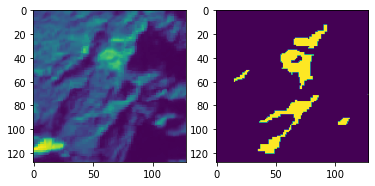

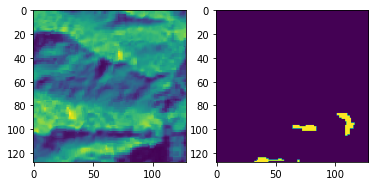

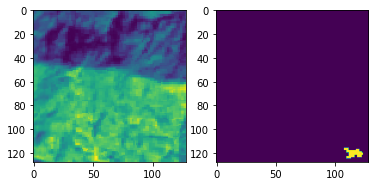

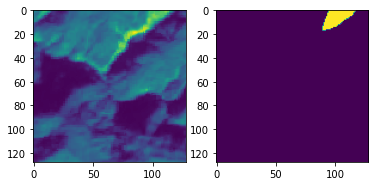

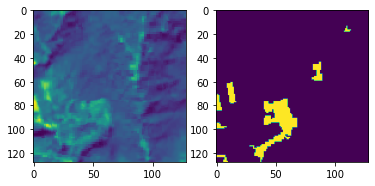

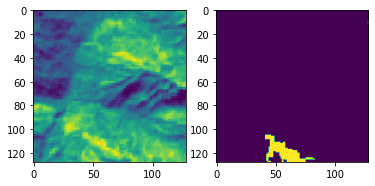

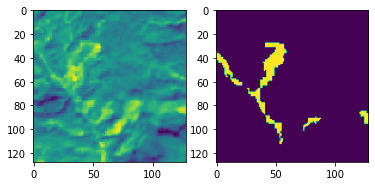

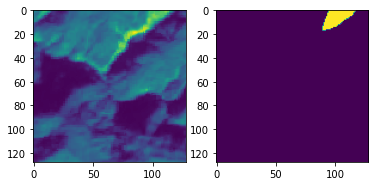

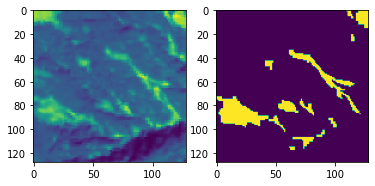

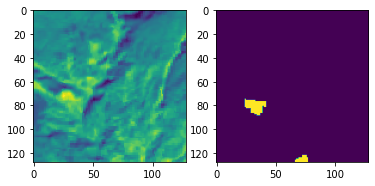

In [12]:
# def plotting (x ,y):
#   n = np.random.randint(0,100)
#   plt.subplot(121)
#   plt.imshow(x[n][:,:,10])
#   plt.subplot(122)
#   plt.imshow(y[n])

# for i in range(10):
#     plt.figure()
#     plotting(X_train,Y_train)


In [65]:
# X_train.shape

(3798, 128, 128, 14)

In [40]:
# #binary_crossentropy = tf.keras.losses.BinaryCrossentropy()
# import keras.backend as K
# def dice_coef(y_true, y_pred):
#         y_true = tf.cast(y_true, tf.float32)  # -------------------------------------------------- explicit cast
#         y_true = K.flatten(y_true)
#         y_pred = K.flatten(y_pred)
#         intersection = K.sum(y_true * y_pred)
#         return 2.0 * intersection / (K.sum(y_true) + K.sum(y_pred) + 1.)

# ## function for measuring loss value
# def dice_coef_loss(y_true, y_pred):
#     y_true = tf.cast(y_true, tf.float32)  # -------------------------------------------------- explicit cast
#     return 1.0 - dice_coef(y_true, y_pred)

# ## Merge loss
# def bce_dice_loss(y_true, y_pred):
#     y_true = tf.cast(y_true, tf.float32)  # -------------------------------------------------- explicit cast
#     a = 0.5
#     b = 1-a
#     loss = a * K.binary_crossentropy(y_true, y_pred) + b * dice_coef_loss(y_true, y_pred)
#     return loss

In [41]:
# #Build the model
# IMG_HEIGHT = 128
# IMG_WIDTH = 128
# IMG_CHANNELS = 14
# inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# #Contraction path
# c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
# c1 = tf.keras.layers.Dropout(0.1)(c1)
# c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
# p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
# c2 = tf.keras.layers.Dropout(0.1)(c2)
# c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
# p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
# c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
# c3 = tf.keras.layers.Dropout(0.2)(c3)
# c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
# p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
# c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
# c4 = tf.keras.layers.Dropout(0.2)(c4)
# c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
# p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
# c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
# c5 = tf.keras.layers.Dropout(0.3)(c5)
# c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# #Expansive path 
# u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
# u6 = tf.keras.layers.concatenate([u6, c4])
# c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
# c6 = tf.keras.layers.Dropout(0.2)(c6)
# c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
# u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
# u7 = tf.keras.layers.concatenate([u7, c3])
# c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
# c7 = tf.keras.layers.Dropout(0.2)(c7)
# c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
# u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
# u8 = tf.keras.layers.concatenate([u8, c2])
# c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
# c8 = tf.keras.layers.Dropout(0.1)(c8)
# c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
# u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
# u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
# c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
# c9 = tf.keras.layers.Dropout(0.1)(c9)
# c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
# outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
# model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 14 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 14) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 2032        lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
# history = model.fit(X_train,Y_train,epochs=150,verbose = 1, batch_size=4,validation_split=0.2)

Epoch 1/150
